## Yum or Yuck Butterfly Mimics 2022 – Baseline Model

**Author:** [Keith Pinson](https://github.com/keithpinson)<br>
**Date created:** 2022/06/11<br>
**Version:** 1.0.0001<br>
**Description:** A simple transfer learning model to establish a baseline score for a Kaggle Community Competition where we try to classify the name of the butterfly in each given image.<br>
**Platform:** Kaggle Packages including Tensorflow 2.6.3 with GPU support<br>
<br>

![Butterfly Classification Diagram](DocResources/ButterflyClassificationTransferLearning-854.png)

We will use EfficientNet convolutional neural network with the Imagenet dataset and re-train the weights.  The final classification layers will be replaced with our own very simple layer to make the butterfly classifier. We will not do any fine-tuning of the pre-trained model although we will allow the network to retrain by not freezing the weights.

In [1]:
import datetime

print("executed",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),"local time")

executed 2022-07-27 09:53:56 local time


---
Using TensorFlow we will a build a butterfly image classifier that will be able to identify 6 remarkable North American butterflies. The Monarch and Pipevine caterpillars sequester toxins: cardiac glycoside and aristolochic acid, from their host plants as they feed. Birds find these butterflies distasteful. They are yucky. The other butterflies mimic the Monarch or Pipevine butterflies and are yummy. Well, except for the Viceroy, since it is both yucky and a mimic, as it sequesters salicylic acid when a caterpillar.

Our goal in this competition is to accurately identify the butterflies by name.

![Images of Black, Monarch, Pipevine, Spicebush, Tiger and Viceroy butterflies from the dataset](DocResources/the-butterflies.png)

<br>

The YOYMimics-2022 dataset has labels to support:

 1. Classification (butterfly species)
 2. Binary classification (yum or yuck)
 3. Multi-label classification (species and wing side)

The competition uses only classification of butterfly species in its scoring metric.
<br>

### <u>This notebook will</u>:

 - Load EfficientNet with the pre-trained Imagenet weights
 - Load the Butterfly Mimics dataset
 - Create a new set of feature weights using our own classifier
 - Predict the butterflies from the test
 - Show a sample of the results
 - Quantify the accuracy of the results



---
## Set Hyperparameters
---

In [2]:
# Hyper-parameters
LEARNING_RATE = 3e-6
EPOCHS = 400
REPEATS = 2

# Other constants
IMAGE_WIDTH = IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)  # Row,Column order
IMAGE_DEPTH = 3
BATCH_SIZE = 32
BUFFER_SIZE = 1024
MODEL_NAME = 'yoymimics'

SEED = 43

##
---
## Set Environment
---


In [3]:
import os
import random

import tensorflow as tf

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Using TensorFlow's enhanced version of Numpy
import tensorflow.experimental.numpy as np
np.experimental_enable_numpy_behavior()

AUTOTUNE = tf.data.experimental.AUTOTUNE

import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt, patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.metrics import \
    fbeta_score, \
    confusion_matrix, \
    ConfusionMatrixDisplay, \
    classification_report

import IPython.display as display

from keras.callbacks import EarlyStopping
from keras.layers import \
    Dense, \
    RandomRotation, \
    RandomZoom


os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed = SEED
np.random.seed = SEED
tf.random.set_seed(SEED)

print(f"Tensorflow {tf.__version__}", "with GPU support" if len(tf.config.list_physical_devices('GPU')) > 0 else "for CPU only")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060 SUPER, compute capability 7.5
Tensorflow 2.6.3 with GPU support


### <u>Dataset paths and names</u>


In [4]:
dataset_name = "YOYMimics-2022-dataset"

# Setting the variables assuming a Windows platform
base_dir = "."
data_dir = os.path.join(base_dir, dataset_name, 'data', 'butterfly_mimics')
working_dir = os.path.join(os.environ.get("HOMEPATH"), dataset_name)
temp_dir = os.path.join(os.environ.get("TMP"), dataset_name)

train_dir = os.path.join(data_dir, 'images')
test_dir = os.path.join(data_dir, 'image_holdouts')
train_csv = os.path.join(data_dir, 'images.csv')
test_csv = os.path.join(data_dir, 'image_holdouts.csv')

class_names = ['black', 'monarch', 'pipevine', 'spicebush', 'tiger', 'viceroy']
name_tastes = {'black':'yum', 'monarch':'yuck', 'pipevine':'yuck', 'spicebush':'yum', 'tiger':'yum', 'viceroy':'yuck'}
class_count = len(class_names)
yums = ['black','spicebush','tiger']
yucks = ['monarch','pipevine','viceroy']


### <u>Convenient functions</u>

In [5]:
def decode_image(image):
    # image.shape == tf.TensorShape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
    return tf.keras.utils.array_to_img(image.numpy())

def decode_label(label):
    # label.shape == tf.TensorShape([class_count])
    return butterfly_classes[tf.argmax(label)].numpy().decode('UTF-8')

def decode_image_id(image_id):
    # image_id.shape == tf.TensorShape([1])
    return image_id.numpy()[0].decode('UTF-8')

def get_error_type(name:str, predicted_name:str):
    if name_tastes[name]=='yum' and name_tastes[predicted_name]=='yum':
        error_string='TP'
    elif name_tastes[name]=='yum' and name_tastes[predicted_name]=='yuck':
        error_string='FN'
    elif name_tastes[name]=='yuck' and name_tastes[predicted_name]=='yum':
        error_string='FP'
    elif name_tastes[name]=='yuck' and name_tastes[predicted_name]=='yuck':
        error_string='TN'
    else:
        error_string = ''

    return error_string


##
---
## Load the Model
---

Note: that final, top layer is not included. We will replace these dense layers of the image classifier with our own.

In [6]:
# EfficientNetV2 was not added until TensorFlow 2.8
from keras.applications.efficientnet import EfficientNetB1

headless_efficientnet = EfficientNetB1(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH)
)

print("Shape of pre-trained network:", headless_efficientnet.output_shape[1:])


Shape of pre-trained network: (7, 7, 1280)


In [7]:
base_model = headless_efficientnet

##
---
## Build the Butterfly Classifier
---

This is the new classifier that replaces the top layer of the pre-trained model. We will *fit* the model with our dateset in a later step, below.

In [8]:
def butterfly_classifier(x):

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # This is the place to improve the classifier.
    # As an example you could:
    #
    # x = Dropout(0.2)(x)
    # x = Dense(512, activation='relu')(x)

    return x


In [9]:
inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))

# We wind our way from inputs to outputs
x = inputs

x = RandomRotation(factor=0.2, fill_mode='nearest')(x)
x = RandomZoom((-0.2, 0.2), fill_mode='nearest')(x)
x = base_model(x, training=True)  # To run in inference mode set training=False
x = butterfly_classifier(x)

outputs = Dense(class_count, activation='softmax')(x)


butterfly_model = tf.keras.Model(inputs, outputs, name=MODEL_NAME)


In [10]:
butterfly_model.summary()

Model: "yoymimics"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 7, 7, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 6,582,925
Trainable params: 6,520,870
Non-trainable params: 62,055
__________________________________________

In [11]:
layer = butterfly_model.layers[-1]
print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))
print("trainable_variables:", len(butterfly_model.trainable_variables))
print("non_trainable_variables:", len(butterfly_model.non_trainable_variables))


weights: 2
trainable_weights: 2
non_trainable_weights: 0
trainable_variables: 301
non_trainable_variables: 141


---
## Build Dataset Pipeline
---

The Butterfly Mimics 2022 Dataset consists of JPG images of a single butterfly. In the training data we are given a label that identifies the class of each butterfly as either *black*, *monarch*, *pipevine*, *spicebush*, *tiger*, or *viceroy*.<br>

![Tiger Swallowtail Butterfly](DocResources/tiger_female_dark_form_vyaa1ee082.jpg)
<br>

```python
X = vyaa1ee082.jpg # Features
y = "tiger"        # Target
```

The dataset provides two folders of images. One with class labels for training. And, one without class labels to test your model for the Public Leaderboard.

- Training data is referred to as the `'images'`
- Test data is referred to as the `'image_holdouts'`

No data from the `'image_holdouts'` is used to generate our baseline scores.

### Our ETL Pipeline:
###
| <u>Extract</u> | <u>Transform</u> | <u>Load</u> |
| :----- | :------- | :-- |
| *Read* dataset stored locally on disk | Step 1: *Split* into training and evaluating sets | *Feed* the data to the model |
|                                     | Step 2: *Pre-process* |
|                                     | Step 3: *Map* image names to image features |


### <u>Read</u>

In [12]:
presplit_csv_data = pd.read_csv(train_csv)
test_csv_data = pd.read_csv(test_csv)

butterfly_count = len(presplit_csv_data)


### <u>Our own Test Split</u>
A test split is provided with the dataset but it does not include the class labels. For this notebook we want to know the actual class labels. So, instead of using the provided test split we will create our own. We call it 'eval'. With it, we will compare actual labels to predicted near the end of the notebook.

We will split the dataset into training and validation in a little bit further below.

In [13]:
# Eval is a very simple split
eval_fraction = 0.25
eval_count = int(butterfly_count//BATCH_SIZE * eval_fraction + 0.5) * BATCH_SIZE
train_count = butterfly_count - eval_count

train_csv_data = presplit_csv_data[:train_count]
eval_csv_data = presplit_csv_data[train_count:]

### <u>Map and Preprocess</u>

We define some mapping functions that we will use in the TensorFlow pipeline. Pay particular attention to `tf.numpy_function()`, without it this workflow of reading the CSV and then loading our images later would not easily work using TensorFlow data.Dataset.

In [14]:
butterfly_classes = np.array(class_names, dtype='str')

def get_feature_and_label_function(image_id, class_name):
    _image_id = image_id[0].decode('UTF-8')
    _class_name = class_name[0].decode('UTF-8')

    _img = tf.io.read_file(os.path.join(
        train_dir, _image_id + '.jpg'))

    _img = tf.image.decode_jpeg(_img,
        channels=IMAGE_DEPTH,
        dct_method='INTEGER_ACCURATE',
        name=_image_id)

    _img = tf.image.resize(_img,IMAGE_SIZE)

    _img = tf.cast(_img, tf.float32)/255.0

    name_label = tf.convert_to_tensor(_class_name)

    one_hot = name_label == butterfly_classes

    # encoded_label = tf.argmax(one_hot)
    encoded_label = one_hot.astype(np.float32)

    return _img, encoded_label, image_id

def get_feature_and_label(x,y):

    features_labels = tf.numpy_function(
        get_feature_and_label_function,
        [x,y],
        [tf.float32,tf.float32,tf.string]
    )

    # numpy_function() loses the shapes, we will need to restore them

    features_labels[0].set_shape(
        tf.TensorShape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
    )

    features_labels[1].set_shape(tf.TensorShape([class_count]))

    features_labels[2].set_shape(tf.TensorShape([1]))
    tf.cast(features_labels[2], tf.string, name='image_id')

    return features_labels

def clear_label(image_feature, label, image_id):
    _label = np.array([0.,0.,0.,0.,0.,0.],dtype=np.float32)
    return image_feature, _label, image_id

def drop_image_id(image_feature, label, image_id):
    return image_feature, label

def train_preprocess(image_feature, label):
    _img = tf.image.random_flip_left_right(image_feature)

    _img = tf.image.random_brightness(_img, max_delta=32.0 / 255.0)
    _img = tf.image.random_saturation(_img, lower=0.5, upper=1.5)

    # Make sure the image is still in [0, 1]
    _img = tf.clip_by_value(_img, 0.0, 1.0)

    return _img, label


Map the strings into the actual tensors and vectors.

In [15]:
# Map the entire dataset as well as an eval dataset that
# is a stand-in in this notebook for the test dataset

# Butterfly Dataset
butterfly_images = pd.DataFrame(presplit_csv_data[['image']].values.tolist())
butterfly_names = pd.DataFrame(presplit_csv_data[['name']].values.tolist())

butterfly_ds_prebatch = tf.data.Dataset.from_tensor_slices((butterfly_images,butterfly_names))
butterfly_ds_prebatch = butterfly_ds_prebatch.map(get_feature_and_label , num_parallel_calls=AUTOTUNE)

# Eval Dataset
eval_images = pd.DataFrame(eval_csv_data[['image']].values.tolist())
eval_names = pd.DataFrame(eval_csv_data[['name']].values.tolist())

eval_ds_prebatch = tf.data.Dataset.from_tensor_slices((eval_images,eval_names))
eval_ds_prebatch = eval_ds_prebatch.map(get_feature_and_label , num_parallel_calls=AUTOTUNE)


### <u>Training/Validation Split</u>

In [16]:
# Shuffle and the do a simple split

butterfly_ds_prebatch.shuffle(butterfly_count, reshuffle_each_iteration=False)

train_ds_prebatch = butterfly_ds_prebatch.take(train_count)     # For training
validate_ds_prebatch = butterfly_ds_prebatch.skip(train_count)  #   and validating during Fit()

print(f"length: {len(train_ds_prebatch)} train / {len(validate_ds_prebatch)} validate")


length: 629 train / 224 validate


### <u>Augmentation Preprocessing</u>

In [17]:
# At this point our datasets have an image, label, and image_id component...

train_ds_prebatch = train_ds_prebatch.map(drop_image_id)        # Drop image id
validate_ds_prebatch = validate_ds_prebatch.map(drop_image_id)  # Drop image id

# Finish preprocessing Training Dataset
train_ds_prebatch = train_ds_prebatch.repeat(REPEATS)
train_ds_prebatch = train_ds_prebatch.map(train_preprocess, num_parallel_calls=AUTOTUNE)
train_ds_prebatch = train_ds_prebatch.cache()
train_ds_prebatch = train_ds_prebatch.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)

# Just cache the validation dataset, hold off on any preprocessing
validate_ds_prebatch = validate_ds_prebatch.cache()


Let's pause for moment and walk a batch through our model and make sure things are working as we expect.

In [18]:
x, y = next(iter(train_ds_prebatch.batch(BATCH_SIZE)))

print("                   Shapes")
print("                   ------")
print("     input batch: ", x.shape)
x = base_model(x)
print("      base model: ", x.shape)
x = butterfly_classifier(x)
print("classifier model: ", x.shape)
x = Dense(class_count)(x)
print("prediction layer: ", x.shape)


                   Shapes
                   ------
     input batch:  (32, 224, 224, 3)
      base model:  (32, 7, 7, 1280)
classifier model:  (32, 1280)
prediction layer:  (32, 6)


Shapes:
<ShuffleDataset shapes: ((224, 224, 3), (6,)), types: (tf.float32, tf.float32)>

image shape: (224, 224, 3)
label shape: (6,) 			 tf.Tensor([0. 1. 0. 0. 0. 0.], shape=(6,), dtype=float32)

monarch


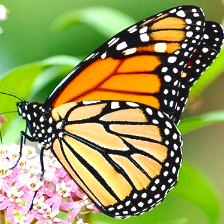

In [19]:
# Check the shapes that the mapping gave us
print("Shapes:")
print(train_ds_prebatch)
print()
image, label = next(iter(train_ds_prebatch.skip(2)))
print("image shape:", image.shape)
print("label shape:", label.shape, "\t\t\t", label)
print()
print(decode_label(label))
display.display(decode_image(image))


### <u>Load</u>

We first batch the datasets and then they will be loaded by the TensorFlow model.fit() method.

In [20]:
# Batch and prefetch the datasets now
train_ds_batch = train_ds_prebatch.batch(BATCH_SIZE)
train_ds = train_ds_batch.prefetch(AUTOTUNE)

eval_ds = eval_ds_prebatch.batch(BATCH_SIZE)

validate_ds_batch = validate_ds_prebatch.batch(BATCH_SIZE)
validate_ds = validate_ds_batch.prefetch(AUTOTUNE)

We can confirm the dataset is ready by taking a peek at the first batch.

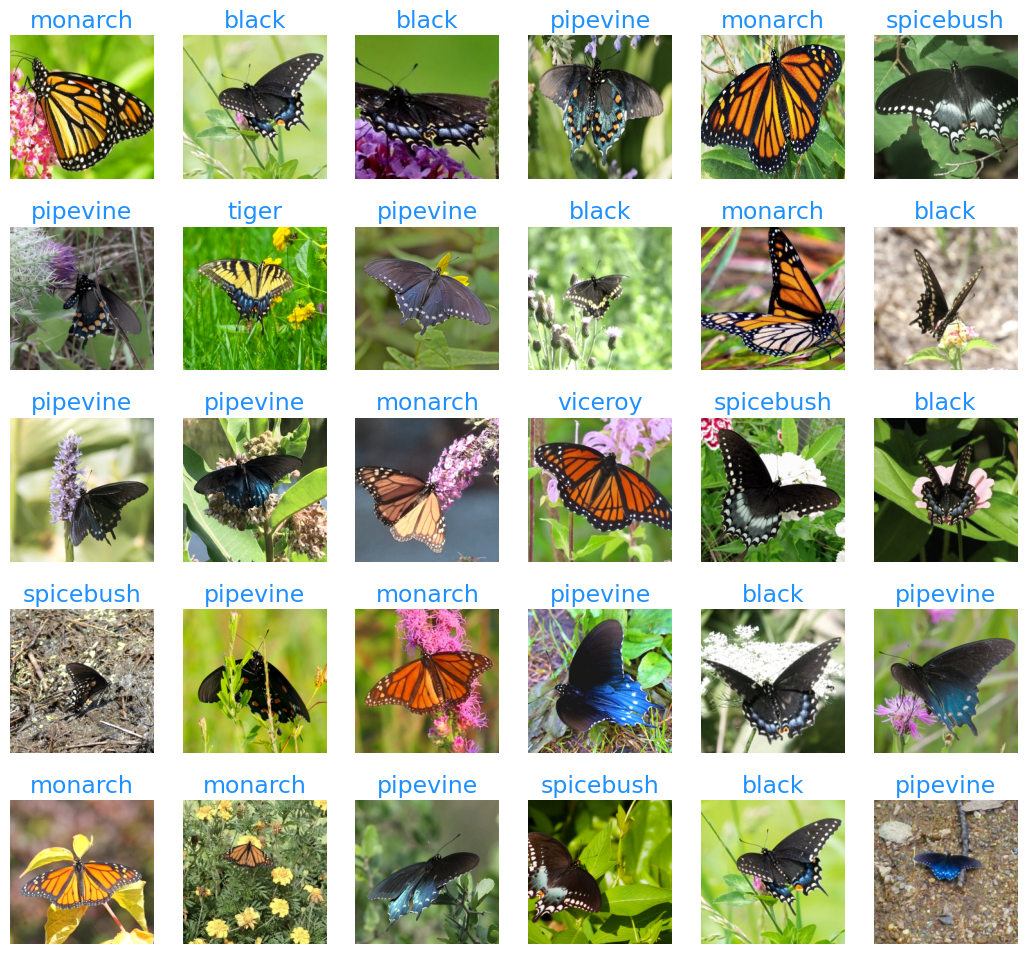

In [21]:
plt.style.use("default")
plt.figure(figsize=(13,12))

# Get the first batch
image_batch, label_batch = next(iter(train_ds))

rows = 5
cols = 6
for i in range(rows*cols):
    butterfly_image = decode_image(image_batch[i])
    butterfly_label = decode_label(label_batch[i])

    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(butterfly_image)
    plt.title(butterfly_label, color="dodgerblue", fontsize=17)
    plt.axis("off")

plt.show()


---
## Train the Model
---

We will compile() and fit() to train our model with given dataset.

In [22]:
stop_early = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=50,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

base_model.trainable = True  # Freeze or don't freeze weights in all layers

butterfly_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy'])

fit_history = butterfly_model.fit(
    train_ds,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[stop_early],
    validation_data=validate_ds,
    verbose=1
)


Epoch 1/400
40/40 [==============================] - 34s 334ms/step - loss: 1.8830 - accuracy: 0.1415 - val_loss: 1.8768 - val_accuracy: 0.1696
Epoch 2/400
40/40 [==============================] - 9s 230ms/step - loss: 1.8552 - accuracy: 0.1558 - val_loss: 1.8252 - val_accuracy: 0.2232
Epoch 3/400
40/40 [==============================] - 9s 229ms/step - loss: 1.8242 - accuracy: 0.1804 - val_loss: 1.7773 - val_accuracy: 0.1964
Epoch 4/400
40/40 [==============================] - 9s 230ms/step - loss: 1.7880 - accuracy: 0.2114 - val_loss: 1.7388 - val_accuracy: 0.2812
Epoch 5/400
40/40 [==============================] - 9s 229ms/step - loss: 1.7666 - accuracy: 0.2353 - val_loss: 1.7172 - val_accuracy: 0.3125
Epoch 6/400
40/40 [==============================] - 9s 231ms/step - loss: 1.7198 - accuracy: 0.2655 - val_loss: 1.7055 - val_accuracy: 0.3214
Epoch 7/400
40/40 [==============================] - 9s 231ms/step - loss: 1.6892 - accuracy: 0.2917 - val_loss: 1.6486 - val_accuracy: 0.375

---
## Visualize the Training
---

If the val_loss is wildly oscillating and/or the accuracy has quickly achieved good accuracy, then cooling the learning rate down may help. The LEARNING_RATE is a hyperparameter set in a cell near the top of the notebook.

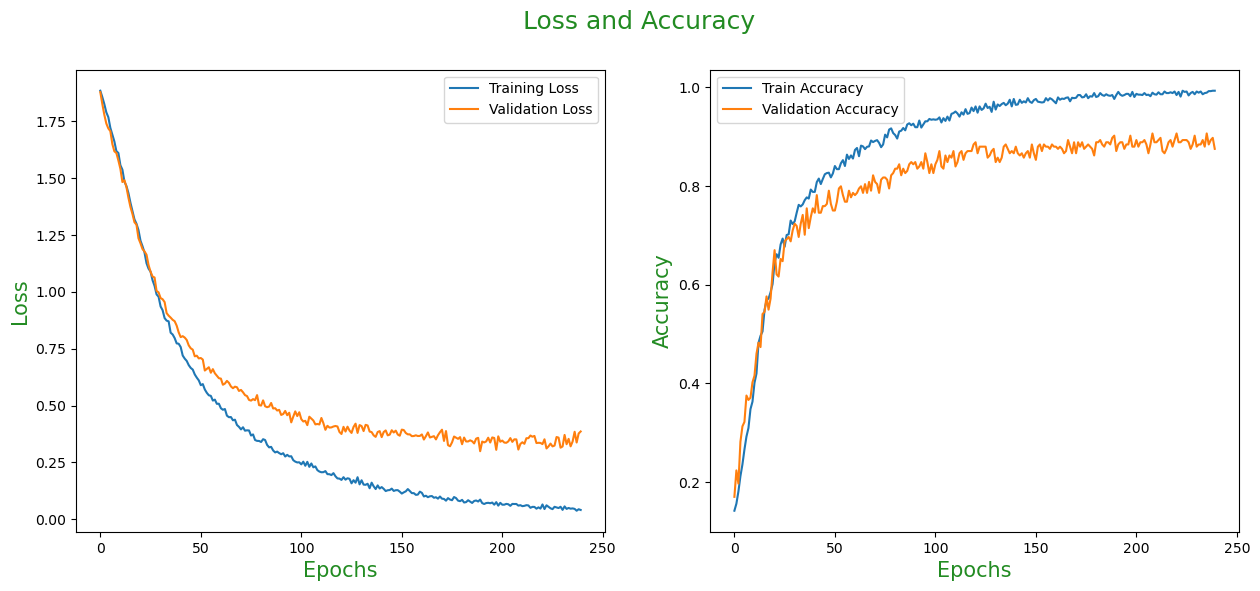

In [23]:
plt.figure(figsize=(15,6))
plt.style.use("default")

plt.suptitle('Loss and Accuracy', fontsize=18, color="forestgreen")

# Visualize Loss vs Epochs
plt.subplot(1,2,1)
plt.plot(fit_history.history['loss'], label='Training Loss')
plt.plot(fit_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs', fontsize=15, color="forestgreen")
plt.ylabel('Loss', fontsize=15, color="forestgreen")

# Visualize Accuracy vs Epochs
plt.subplot(1,2,2)
plt.plot(fit_history.history['accuracy'], label='Train Accuracy')
plt.plot(fit_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs', fontsize=15, color="forestgreen")
plt.ylabel('Accuracy', fontsize=15, color="forestgreen")
plt.show()

In [24]:
# Now that the model is trained we can evaluate it
eval_result = butterfly_model.evaluate(validate_ds)
dict(zip(butterfly_model.metrics_names, eval_result))

7/7 [==============================] - 1s 69ms/step - loss: 0.3126 - accuracy: 0.9018


{'loss': 0.3126220703125, 'accuracy': 0.9017857313156128}

---
## Make the Predictions
---

Like `evaluate()` which we just ran, we can run `predict()` but we will have to do some work to visualize the results.

In [25]:
y_predictions = butterfly_model.predict(eval_ds, verbose=1)

7/7 [==============================] - 4s 109ms/step


In [26]:
def decode_predictions(preds, name_list, top=1):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]

        result = [tuple([name_list[i]]) + (pred[i], ) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)

    return results

predicted_label_confidence = decode_predictions(y_predictions, class_names)


In [27]:
# Combine the actual and predicted data together into a single list
es = eval_ds_decoded = [(decode_image(m),decode_label(l),decode_image_id(id)) for (m, l, id) in eval_ds.unbatch()]
ps = predicted_label_confidence

# Zip the tuples, manually
predictions_df = pd.DataFrame(
    [(es[i][2],             # id
      es[i][0],             # X
      es[i][1],             # y
      es[i][1] in yums,     # yum
      ps[i][0][0],          # y_pred
      ps[i][0][0] in yums,  # yum_pred
      ps[i][0][1],          # y_conf
      get_error_type(es[i][1], ps[i][0][0])
    ) for i in range(len(es))],
    columns=['id','X','y','yum','y_pred','yum_pred','y_conf','yum_err'])

predictions_df.head()


id                                                  X         y  \
0  uy02c3f5a1  <PIL.Image.Image image mode=RGB size=224x224 a...     tiger   
1  uy631e9681  <PIL.Image.Image image mode=RGB size=224x224 a...   viceroy   
2  uyae957499  <PIL.Image.Image image mode=RGB size=224x224 a...  pipevine   
3  uyc3225f0a  <PIL.Image.Image image mode=RGB size=224x224 a...     black   
4  uz4b7e7a2d  <PIL.Image.Image image mode=RGB size=224x224 a...   viceroy   

     yum    y_pred  yum_pred    y_conf yum_err  
0   True     tiger      True  0.999512      TP  
1  False   viceroy     False  0.888184      TN  
2  False  pipevine     False  0.999512      TN  
3   True     black      True  0.999512      TP  
4  False   viceroy     False  0.849121      TN

uz4b7e7a2d, viceroy


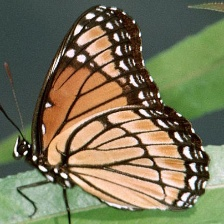

In [28]:
i = 4

print(f"{predictions_df.loc[i,'id']}, {predictions_df.loc[i,'y']}")
display.display(predictions_df.loc[i,'X'])

---
## Visualize Results
---

In [29]:
j = 0
show_actual = True

yuck_icon = mpl.image.imread('./DocResources/face-vomiting_1f92e.png')
icon_size = yuck_icon.shape[1], yuck_icon.shape[0]


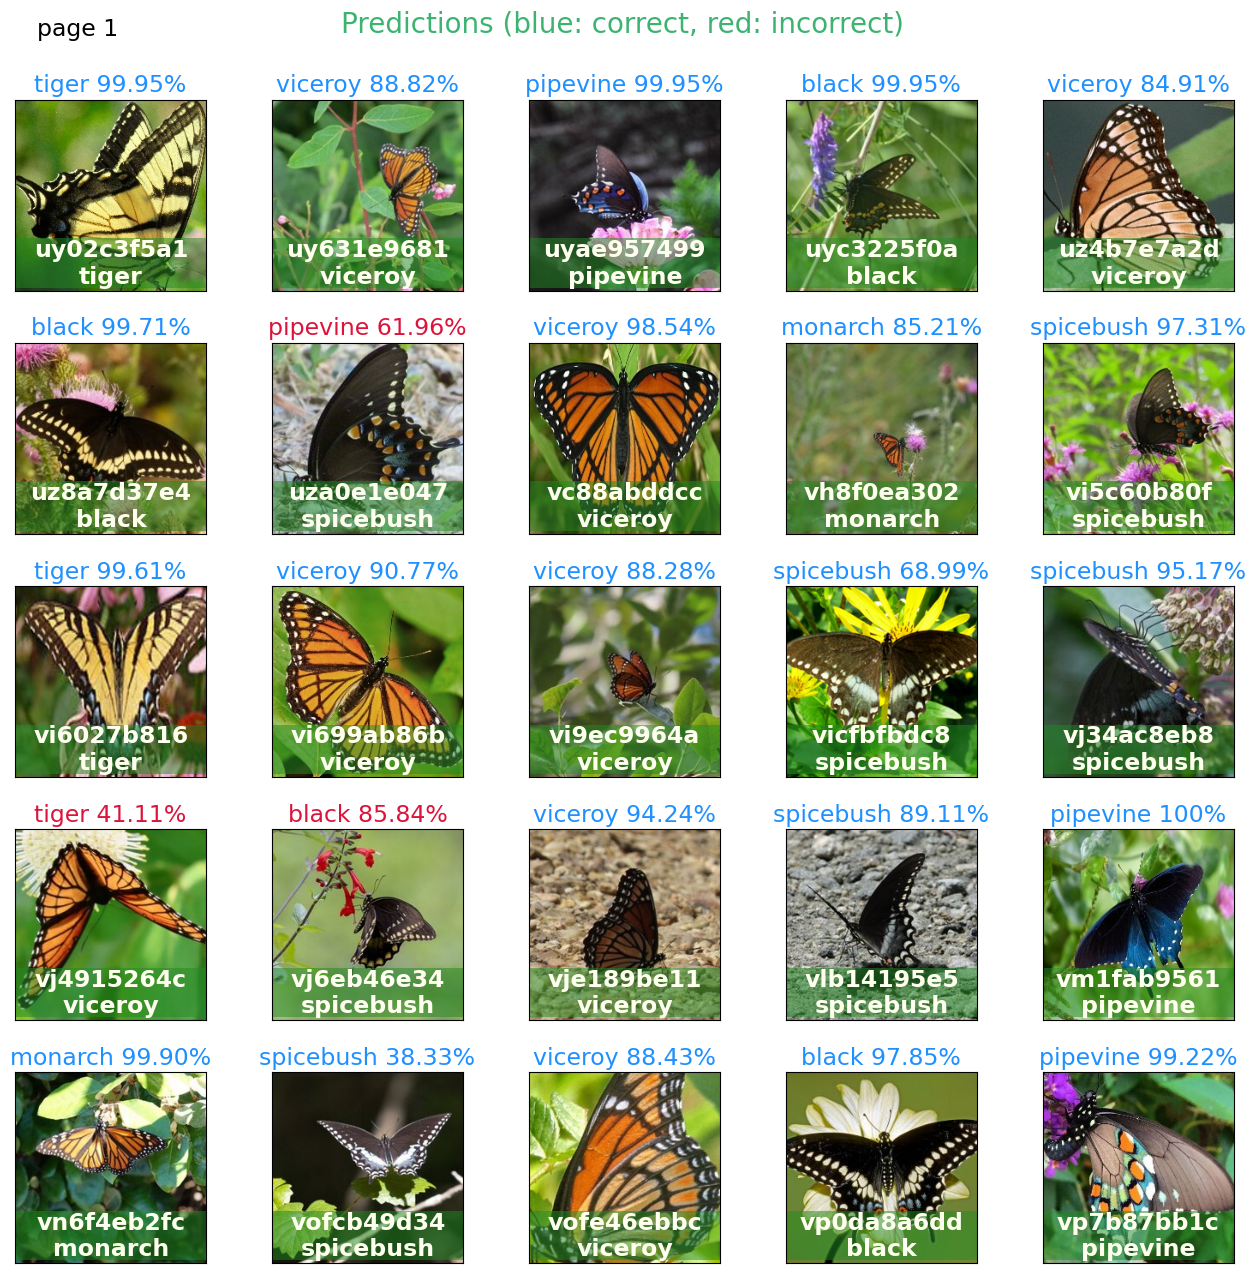

In [30]:
# Run this cell over and over to step through the predictions

rows = 5
cols = 5

plt.style.use("default")
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(13, 13),
                        subplot_kw={'xticks': [], 'yticks': []})

plt.suptitle("Predictions (blue: correct, red: incorrect)\n", color="mediumseagreen", fontsize=20)

maxloop = len(predictions_df)//(rows*cols)

if j <= maxloop:
    for i, ax in enumerate(axs.flat):
        k = (j*rows*cols) + i

        if k < len(predictions_df):

            a_name = predictions_df.loc[k,'y']
            p_name = predictions_df.loc[k,'y_pred']
            p_confidence = predictions_df.loc[k,'y_conf']
            p_percent = "{:.2%}".format(p_confidence) \
                if p_confidence < 1.0 else "100%"

            a_description = f"{predictions_df.loc[k,'id']}\n{a_name}"
            p_description = f"{p_name} {p_percent}"

            # Disable False-positive icon display
            is_fp = False  # = predictions_df.loc[k,'yum_err'] == 'FP'

            color = "dodgerblue" if a_name == p_name else "crimson"

            ax.grid(None)
            ax.axis('on')

            ax.set_title(p_description, color=color, fontsize=17)

            ax.imshow(predictions_df.loc[k,'X'], interpolation_stage='rgb', alpha=1.0)

            if is_fp:
                offset_img = OffsetImage(yuck_icon, zoom=.7)
                ab = AnnotationBbox(offset_img, (2, 22), frameon=False)
                ax.add_artist(ab)

            if show_actual:
                rectangle = patches.Rectangle((0, IMAGE_HEIGHT-62), IMAGE_WIDTH, 58, facecolor="forestgreen", linewidth=0, alpha=.5)
                ax.add_patch(rectangle)

                ax.annotate(a_description, (IMAGE_WIDTH//2, IMAGE_HEIGHT-33), color='ivory', weight='bold', fontsize=17, ha='center', va='center')

            ax.set(xticks=[], yticks=[], xlabel='')
        else:
            ax.set_visible(False)

    fig.text(.05, .96, f"page {j+1}", color='k', fontsize=17)

    j = j + 1 if j < maxloop else 0
    plt.tight_layout(h_pad=1.5)
    plt.show()

---
## Save the CSV
---

If our model is good this is the last step.

In [31]:
# Change the dataframe to match the expected submission CSV
submit_df = predictions_df[['id', 'y_pred', 'y_conf']]
submit_df.columns=['image','name','confidence']

submit_df.to_csv("submission.csv", header=True, index=False)

print('CSV file saved')

print(submit_df)


CSV file saved
          image       name  confidence
0    uy02c3f5a1      tiger    0.999512
1    uy631e9681    viceroy    0.888184
2    uyae957499   pipevine    0.999512
3    uyc3225f0a      black    0.999512
4    uz4b7e7a2d    viceroy    0.849121
..          ...        ...         ...
219  zy16ddb9f1      black    0.993164
220  zy67bc70c5   pipevine    0.975586
221  zz27202dc0  spicebush    0.888672
222  zzd5daae92  spicebush    0.915039
223  zze50f4f4f      black    0.770996

[224 rows x 3 columns]


# &nbsp;
---
## Code for Visualizations
---
This section contains Python definitions to help visualize our results. Apologies for the length of the code, but it is necessary for making better visualizations. This code does not need to be reviewed to understand the model.


In [32]:
def plot_confusion_matrix(cm, cmap=None, title=None,
                          y_labels=None, x_labels=None,
                          binary_flip=True,
                          error_1_text = '',
                          error_2_text = '',
                          show_annotations=True,
                          quad_line=True,  # True/False or width of true-positives
                          size=(8,6)):

    is_binary = len(cm.ravel()) == 4

    # Binary matrices will unravel in this order:
    # tn, fp, fn, tp = cm.ravel()
    # Binary labels should be in False,True or 0,1 order

    tn_c = (0,0)  # True Negative top-left corner
    fp_c = (0,1)
    fn_c = (1,0)
    tp_c = (1,1)

    _cm = cm

    if is_binary and binary_flip:
        _cm = np.rot90(np.rot90(cm)).numpy()
        x_labels = list(reversed(x_labels)) if x_labels else None
        y_labels = list(reversed(y_labels)) if y_labels else None
        tn_c = (1,1)  # True Negative bottom-right corner
        fp_c = (1,0)
        fn_c = (0,1)
        tp_c = (0,0)

    plt.style.use("default")

    if y_labels and not x_labels:
        x_labels = y_labels

    if x_labels and not y_labels:
        y_labels = x_labels

    labels = y_labels # either None or both labels set


    # Set the optional ax argument so we can change the figsize()
    fig, ax = plt.subplots(figsize=size)

    if title:
        plt.suptitle(title, color="darkgreen", fontsize=20, y=1.1)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=_cm,
        display_labels=labels,
    )

    if not cmap:
        # Contract the color space
        cmap = plt.get_cmap('RdGy')
        min_v = .15
        max_v = .9
        _cmap = cmap(np.linspace(min_v, max_v, 100))
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=min_v, b=max_v),
            _cmap)
    else:
        cmap = plt.get_cmap(cmap)

    cm_plot = disp.plot(
        ax=ax,
        cmap=cmap,              # 'seismic_r'
        xticks_rotation=37,
        include_values=False,
    )

    ax.set_title("Confusion Matrix", fontsize=18)

    ax.set_ylabel('Actual', fontsize=17)
    ax.set_xlabel('Prediction', fontsize=17)

    if not x_labels:
        x_labels = ax.xaxis.get_ticklabels()

    ax.xaxis.set_ticklabels(x_labels, ha='right')

    ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='dimgrey')

    #
    # Display our own content in the grid
    #

    tm = np.empty_like(_cm, dtype=object).numpy() # Text Matrix

    # print text with appropriate color depending on background
    cmap_ls = cmap(np.linspace(0, 1.0, (_cm.max()-_cm.min())))
    lum_white = 0.9277833117792471
    lum_black = 0.0

    for j in range(tm.shape[0]):
        for i in range(tm.shape[1]):

            # Determine the highest contrast text color
            r,g,b,a = tuple(cmap_ls[_cm[j, i]-_cm.min()-1].tolist())

            lum_r = r / 12.92 if r <= 0.03928 else (r + 0.055)/1.055 ** 2.4
            lum_g = g / 12.92 if g <= 0.03928 else (g + 0.055)/1.055 ** 2.4
            lum_b = b / 12.92 if b <= 0.03928 else (b + 0.055)/1.055 ** 2.4

            lum = 0.2126 * lum_r + 0.7152 * lum_g + 0.0722 * lum_b

            contrast_ratio_light = ((max(lum,lum_white) + 0.05) / (min(lum,lum_white) + 0.05))
            contrast_ratio_dark = ((max(lum,lum_black) + 0.05) / (min(lum,lum_black) + 0.05))

            tm_color = 'k' if contrast_ratio_dark > contrast_ratio_light else 'w'

            # Determine the number formatting
            tm_fmt = format(_cm[j, i], ".2g")
            if _cm.dtype.kind != "f":
                text_d = format(_cm[j, i], "d")
                if len(text_d) < len(tm_fmt):
                    tm_fmt = text_d

            tm[j,i] = {'value':tm_fmt, 'color':tm_color}
            ax.text(y=j, x=i, s=tm_fmt, ha="center", va="center", color=tm_color, fontsize=17)


    if is_binary and show_annotations:

        tm[tn_c]['quadrant'] = '(True Negative)'
        tm[fp_c]['quadrant'] = '(False Positive)'
        tm[fn_c]['quadrant'] = '(False Negative)'
        tm[tp_c]['quadrant'] = '(True Positive)'
        tm[fn_c]['description'] = 'Type II Error\n' + error_2_text
        tm[fp_c]['description'] = 'Type I Error\n' + error_1_text

        for j in range(tm.shape[0]):
            for i in range(tm.shape[1]):
                if tm[j,i].get('quadrant'):
                    ax.text(s=f"{tm[j,i]['quadrant']}",
                        y=j,x=i,
                        position=(i,j+0.25),
                        color=tm[j,i]['color'],
                        fontsize='16',
                        verticalalignment='bottom',
                        horizontalalignment='center',
                    )
                if tm[j,i].get('description'):
                    ax.text(s=f"{tm[j,i]['description']}",
                        y=j,x=i,
                        position=(i,j+0.3),
                        color=tm[j,i]['color'],
                        fontsize='12',
                        fontstyle='italic',
                        verticalalignment='top',
                        horizontalalignment='center',
                    )


    if quad_line:
        # Check to see we have to calculate line position and we have right shape
        if isinstance(quad_line,bool):
            if (len(cm)==len(cm[0]) and len(cm)%2==0):
                quad_line = len(cm)//2
            else:
                quad_line = 0

        if quad_line > 0:
            ax.axhline(y=quad_line-0.5, xmin=0.0, xmax=1.0, color='k')
            ax.axvline(x=quad_line-0.5, ymin=0.0, ymax=1.0, color='k')

    plt.show()


## &nbsp;
---
## Check our Score
---
The competition is using the F1 score as a scoring metric.

For a tabular display `sklearn classification_report()` and `confusion_matrix()` provide nicely formatted displays of useful metrics.

A graphical display of the confusion table can be useful too.

In [33]:
beta = 1
average = 'macro'
print(f"F{beta} score:", fbeta_score(predictions_df[['y']], predictions_df[['y_pred']], beta=beta, average=average))

F1 score: 0.8784858953321507


In [34]:
butterfly_cr = classification_report(predictions_df[['y']], predictions_df[['y_pred']], digits=3, output_dict=False)
print("Butterfly Classification Report")
print()
print(butterfly_cr)


Butterfly Classification Report

              precision    recall  f1-score   support

       black      0.865     0.914     0.889        35
     monarch      0.882     0.909     0.896        33
    pipevine      0.889     0.923     0.906        52
   spicebush      0.885     0.742     0.807        31
       tiger      0.891     0.911     0.901        45
     viceroy      0.889     0.857     0.873        28

    accuracy                          0.884       224
   macro avg      0.883     0.876     0.878       224
weighted avg      0.884     0.884     0.883       224



In [35]:
butterfly_cm = confusion_matrix(predictions_df[['y']], predictions_df[['y_pred']])
print("Butterfly Confusion Matrix")
print()
print(butterfly_cm)


Butterfly Confusion Matrix

[[32  0  0  2  1  0]
 [ 0 30  0  0  0  3]
 [ 1  0 48  1  2  0]
 [ 4  0  3 23  1  0]
 [ 0  1  3  0 41  0]
 [ 0  3  0  0  1 24]]


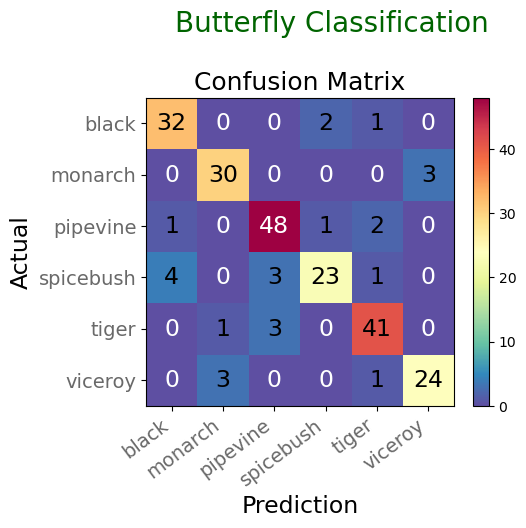

In [36]:
plot_confusion_matrix(butterfly_cm, title="Butterfly Classification", cmap='Spectral_r', y_labels=class_names, size=(5,4), quad_line=False)

## &nbsp;
---
## Further Visualizations
---
Many datasets have additional labels (sometimes stated and sometimes hidden). These additional labels can be incorporated into the model and if done right can decrease overfitting and increase accuracy.

The *2022 Dataset of Butterfly Mimics* provides an additional stated label, `side` which indicates the visible side of the wing shown in the image. A model that first classifies *side* and then butterfly *name* might boost accuracy.

Some hidden labels, these are really heuristics and don't require teasing out with another model, are color and taste. Monarch and viceroys are orange, yellow swallowtails are tigers (the lighter form). Black, spicebush, and tiger butterflies taste yummy. Monarch, pipevine, and viceroy butterflies taste yucky (to birds).

<u>Yum and Yuck in the Confusion Matrix</u>

Let's look at the "yum or yuck" label and see how incorporating it into the Butterfly Confusion Matrix can reveal more information.



TP 104 	|  FN 7
------------------
FP 5 	|  TN 108

Or, viewed as a visualization:



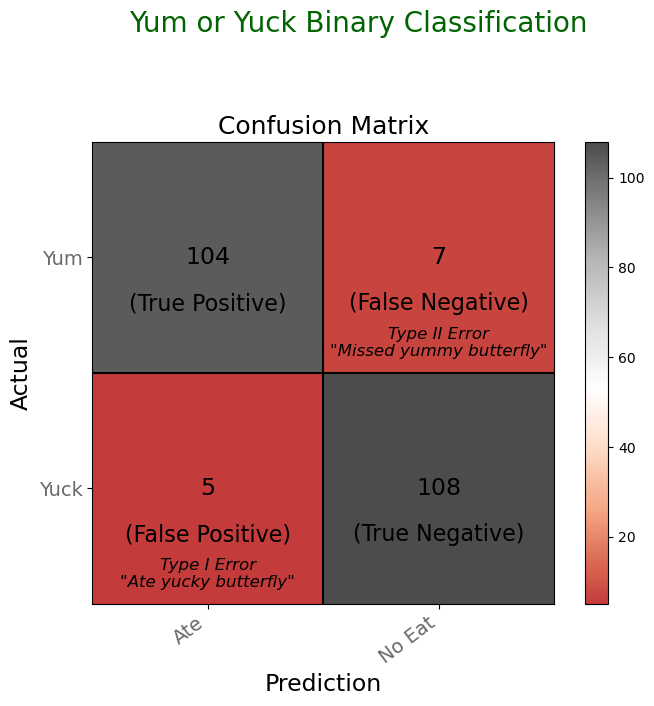

In [37]:
yum_cm = confusion_matrix(predictions_df[['yum']], predictions_df[['yum_pred']])

k_class_names = ['black', 'spicebush', 'tiger', 'monarch', 'pipevine', 'viceroy']
k_butterfly_cm = confusion_matrix(predictions_df[['y']], predictions_df[['y_pred']], labels=k_class_names)

# Note: with binary classifications it is best unravel the confusion matrix as follows:
tn, fp, fn, tp = yum_cm.ravel()

print('TP', tp, "\t| ", 'FN', fn)  # "if Prediction left-right axis then FN is left-right and clockwise to TP"
print('------------------')
print('FP', fp, "\t| ", 'TN', tn)
print()

print("Or, viewed as a visualization:\n")

plot_confusion_matrix(yum_cm,
                      title="Yum or Yuck Binary Classification",
                      y_labels=['Yuck', 'Yum'],
                      x_labels=['No Eat', 'Ate'],
                      error_1_text='"Ate yucky butterfly"',
                      error_2_text='"Missed yummy butterfly"'
)


Let's look at the corresponding butterfly confusion matrix still in yum/yuck order...

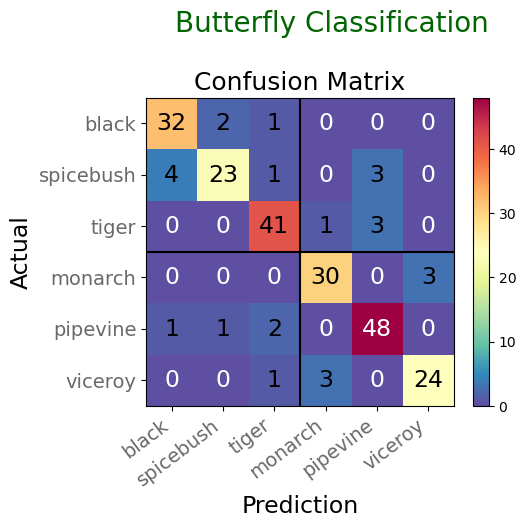

In [38]:
plot_confusion_matrix(k_butterfly_cm, title="Butterfly Classification", cmap='Spectral_r', y_labels=k_class_names, size=(5,4))

While it may not have been clear before, now we can see that the additional label provides Type I and II Error information that could prove useful in improving the overall accuracy of the model.

---
## Next Steps
---

There is much room for improvement. So, some things to try:
 - Use a different base model or roll-your-own model
 - Freeze a portion of the base model
 - Fine-tune the model
 - Change the image augmenting
 - Improve the classifier
 - Incorporate additional label information into the model

In [39]:
tf.keras.backend.clear_session()